# Data Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
import category_encoders as ce
import miceforest as mf

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
df = pd.read_csv('../data/processed/after_prep.csv')
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Series,Type,Mileage (kmpl),Engine (CC),Power (bhp)
0,Mumbai,2010,72000,CNG,Manual,First,5.0,1.75,Maruti,Wagon,R,26.60,998.0,58.16
1,Pune,2015,41000,Diesel,Manual,First,5.0,12.50,Hyundai,Creta,1.6,19.67,1582.0,126.20
2,Chennai,2011,46000,Petrol,Manual,First,5.0,4.50,Honda,Jazz,V,18.20,1199.0,88.70
3,Chennai,2012,87000,Diesel,Manual,First,7.0,6.00,Maruti,Ertiga,VDI,20.77,1248.0,88.76
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,17.74,Audi,A4,New,15.20,1968.0,140.80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Seats              5976 non-null   float64
 7   Price              6019 non-null   float64
 8   Brand              6019 non-null   object 
 9   Series             6019 non-null   object 
 10  Type               6019 non-null   object 
 11  Mileage (kmpl)     5949 non-null   float64
 12  Engine (CC)        5983 non-null   float64
 13  Power (bhp)        5876 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 658.5+ KB


# Preprocessing

## Outlier Handling

In [4]:
df = df[~(df.Kilometers_Driven > 1e6)]
df.shape

(6018, 14)

## Feature Enginering

In [5]:
# Create price zone feature from Location
def zone(data):
    if data in ["Kolkata"]:
        return "Eastern"
    elif data in ["Delhi", "Jaipur"]:
        return "Northern"
    elif data in ["Ahmedabad", "Mumbai", "Pune"]:
        return "Western"
    else:
        return "Southern"

df["Zone"] = df["Location"].apply(zone)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6018 non-null   object 
 1   Year               6018 non-null   int64  
 2   Kilometers_Driven  6018 non-null   int64  
 3   Fuel_Type          6018 non-null   object 
 4   Transmission       6018 non-null   object 
 5   Owner_Type         6018 non-null   object 
 6   Seats              5975 non-null   float64
 7   Price              6018 non-null   float64
 8   Brand              6018 non-null   object 
 9   Series             6018 non-null   object 
 10  Type               6018 non-null   object 
 11  Mileage (kmpl)     5948 non-null   float64
 12  Engine (CC)        5982 non-null   float64
 13  Power (bhp)        5875 non-null   float64
 14  Zone               6018 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 752.2+ KB


## Train test split

In [7]:
# melakukan train test split di awal untuk mencegah data bocor ke test set saat dilakukan encoding/imputation
features = df.drop(columns=['Price'])
target = df['Price']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

## Encoding

In [8]:
# Encoding categorical features
col_to_encode = df.select_dtypes("object").columns.tolist()
encoder = ce.CatBoostEncoder(cols=col_to_encode)
encoder.fit(X_train, y_train)

# Encoding train set
X_train = encoder.transform(X_train)
# Encoding test set
X_test = encoder.transform(X_test)

## Missing Value Imputation

In [9]:
# memprediksi nilai missing value dengan algoritma 
imputer = mf.KernelDataSet(
  X_train,
  save_all_iterations=True,
  random_state=1991,
  mean_match_candidates=5
)
imputer.mice(10)

In [10]:
# Train set imputation
X_train_full = imputer.complete_data()

In [11]:
# Test set imputation
new_data = imputer.impute_new_data(X_test)
X_test_full = new_data.complete_data()

# Modeling

## Functions

In [12]:
def get_cv_score(models, X_train, y_train):
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    summary = []
    for label, model in models.items():
        cv_results = cross_validate(model, X_train, y_train, cv=cv, 
                                    scoring=['r2',
                                             'neg_root_mean_squared_error',
                                             'neg_mean_absolute_error'])
        
        temp = pd.DataFrame(cv_results).copy()
        temp['Model'] = label
        summary.append(temp)
    
    summary = pd.concat(summary)
    summary = summary.groupby('Model').mean()
    
    summary.drop(columns=['fit_time', 'score_time'], inplace=True)
    summary.columns = ['CV R2', 'CV RMSE', 'CV MAE']
    summary[['CV RMSE', 'CV MAE']] = summary[['CV RMSE', 'CV MAE']] * -1
    
    return summary

In [13]:
def evaluate_model(models, X_train, X_test, y_train, y_test):

    summary = {'Model':[], 'Train R2':[], 'Train RMSE':[], 'Train MAE':[],
               'Test R2':[], 'Test RMSE':[], 'Test MAE':[]}

    for label, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        summary['Model'].append(label)

        summary['Train R2'].append(
            metrics.r2_score(y_train, y_train_pred))
        summary['Train RMSE'].append(
            np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
        summary['Train MAE'].append(
            metrics.mean_absolute_error(y_train, y_train_pred))

        summary['Test R2'].append(
            metrics.r2_score(y_test, y_test_pred))
        summary['Test RMSE'].append(
            np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
        summary['Test MAE'].append(
            metrics.mean_absolute_error(y_test, y_test_pred))
    
    summary = pd.DataFrame(summary)
    summary.set_index('Model', inplace=True)

    cv_scores = get_cv_score(models, X_train, y_train)
    summary = summary.join(cv_scores)
    summary = summary[['Train R2', 'CV R2', 'Test R2',
                       'Train RMSE', 'CV RMSE', 'Test RMSE',
                       'Train MAE', 'CV MAE', 'Test MAE']]
    
    return round(summary.sort_values(by='CV RMSE'), 4)

## Base Models

In [14]:
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor(objective='reg:squarederror')
lgb_model = LGBMRegressor()
cat_model = CatBoostRegressor(silent=True)
lr_model = LinearRegression()
lasso_model = Lasso()

models = {'DecisionTreeRegressor' : tree_model,
          'RandomForestRegressor' : rf_model,
          'XGBRegressor' : xgb_model,
          'CatBoostRegressor' : cat_model,
          'LGBMRegressor' : lgb_model,
          'LinearRegression': lr_model,
          'LassoRegression': lasso_model}

In [15]:
evaluate_model(models, X_train_full, X_test_full, y_train, y_test)

,Train R2,CV R2,Test R2,Train RMSE,CV RMSE,Test RMSE,Train MAE,CV MAE,Test MAE
Model,,,,,,,,,
CatBoostRegressor,0.9923,0.9243,0.9144,0.9730,3.0429,3.3403,0.6363,1.1828,1.1745
LGBMRegressor,0.9709,0.9164,0.9140,1.8897,3.1966,3.3471,0.8279,1.2824,1.2663
RandomForestRegressor,0.9873,0.9103,0.9059,1.2507,3.3053,3.5026,0.4772,1.3084,1.3531
XGBRegressor,0.9977,0.9087,0.8795,0.5341,3.3417,3.9629,0.3783,1.2713,1.3200
LinearRegression,0.8006,0.7974,0.7769,4.9474,4.9804,5.3921,2.7301,2.7471,2.9320
LassoRegression,0.7948,0.7930,0.7749,5.0187,5.0351,5.4161,2.6652,2.6799,2.8488
DecisionTreeRegressor,1.0000,0.7643,0.8648,0.0129,5.1814,4.1977,0.0006,1.8965,1.7818


### Feature Importance

In [17]:
xgb_model.fit(X_train_full, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X_train_full.columns)
feat_imp

,0
Location,0.003582
Year,0.049457
Kilometers_Driven,0.011895
Fuel_Type,0.001802
Transmission,0.006292
Owner_Type,0.001030
Seats,0.012992
Brand,0.598534
Series,0.098143
Type,0.039674


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

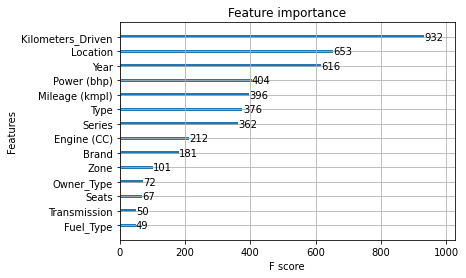

In [25]:
xgb.plot_importance(xgb_model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

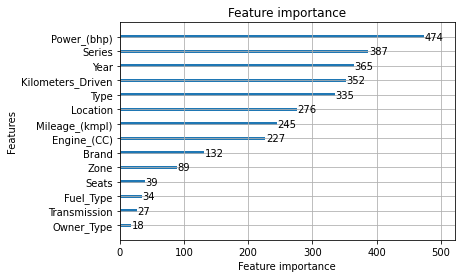

In [29]:
lgb.plot_importance(lgb_model)

In [27]:
lgb_model.feature_importances_

array([276, 365, 352,  34,  27,  18,  39, 132, 387, 335, 245, 227, 474,
        89], dtype=int32)